# [CV_12] 직접 만들어보는 OCR

In [ ]:
!cd /content/drive/MyDrive/Colab Notebooks/data
!wget https://www.dropbox.com/sh/i39abvnefllx2si/AABX4yjNn2iLeKZh1OAwJUffa/data_lmdb_release.zip
!wget https://www.dropbox.com/s/issusv9gteq4x6a/GD10.zip
!unzip '*.zip'
!mv data_lmdb_release/training/MJ .

## Dataset for OCR

In [1]:
import os

path = '/content'
os.chdir(path)

print(path)

/content


In [2]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 256
HOME_DIR = '/content'

TRAIN_DATA_PATH = '/content/data/MJ/MJ_test'
VALID_DATA_PATH = '/content/data/MJ/MJ_train'
TEST_DATA_PATH = '/content/data/MJ/MJ_valid'

print(TRAIN_DATA_PATH)

/content/data/MJ/MJ_test


## Recognition model

original image width:130, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:slinking


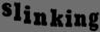

original image width:67, height:31
target_img_size:(69, 32)
display img shape:(69, 32, 3)
label:REMODELERS


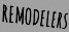

original image width:169, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:Chronographs


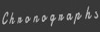

original image width:110, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:Impeaching


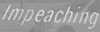

In [3]:
from IPython.display import display

# env에 데이터를 불러오기
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 열기
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있음
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있음
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀 예정
        # 하지만 너비를 100보다는 작게
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있음     
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [4]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비
    # 또, lmdb에 있는 데이터 수를 미리 파악
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어
    # 위에서 사용한 코드와 매우 유사
    # label을 조금 더 다듬는 것이 약간 다름
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬기
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어 있는 메서드
    # 이 부분을 작성하면 slice할 수 있음
    # 자세히 알고 싶다면 아래 문서를 참고
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있음
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

## Encode

In [5]:
class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
             encoded_label.append(self.label_map[char])
         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

In [6]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [7]:
# test
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


## Build CRNN model

In [8]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [9]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

## Train & Inference

In [10]:
# 데이터셋과 모델을 준비
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델 컴파일
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adadelta.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adadelta, self).__init__(name, **kwargs)


In [11]:
# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용
checkpoint_path = '/content/model_checkpoint.hdf5'
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'
)
model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=150,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop])

Epoch 1/150
35/35 [==============================] - ETA: 0s - loss: 30.5244
Epoch 1: val_loss improved from inf to 27.60015, saving model to /content/model_checkpoint.hdf5
35/35 [==============================] - 100s 2s/step - loss: 30.5244 - val_loss: 27.6001
Epoch 2/150
35/35 [==============================] - ETA: 0s - loss: 26.9539
Epoch 2: val_loss improved from 27.60015 to 26.69818, saving model to /content/model_checkpoint.hdf5
35/35 [==============================] - 75s 2s/step - loss: 26.9539 - val_loss: 26.6982
Epoch 3/150
35/35 [==============================] - ETA: 0s - loss: 26.4579
Epoch 3: val_loss improved from 26.69818 to 26.68620, saving model to /content/model_checkpoint.hdf5
35/35 [==============================] - 76s 2s/step - loss: 26.4579 - val_loss: 26.6862
Epoch 4/150
35/35 [==============================] - ETA: 0s - loss: 26.1406
Epoch 4: val_loss improved from 26.68620 to 26.15752, saving model to /content/model_checkpoint.hdf5
35/35 [==================

In [12]:
# 다음은 학습된 모델의 가중치가 저장된 경로
checkpoint_path = '/content/model_checkpoint.hdf5'

# 데이터셋과 모델을 불러오기
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없음
# 따라서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들 예정
# inference 전용 모델
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Result: 	 AMOIOKER9999999999999999


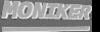

Result: 	 RESHUDTED999999999999999


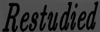

Result: 	 SWERWLI99999999999999999


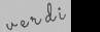

Result: 	 BEBLED99999999999999999


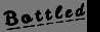

Result: 	 BSDAE999999999999999999


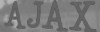

Result: 	 GONSERVES999999999999999


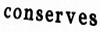

Result: 	 PAVED9999999999999999999


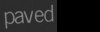

Result: 	 UNLICS999999999999999999


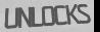

Result: 	 MISTUALING99999999999999


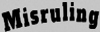

Result: 	 OVERIOY99999999999999999


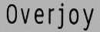

In [13]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

## Visualization

In [14]:
! pip install keras_ocr

In [17]:
from keras_ocr.detection import Detector
import cv2
import matplotlib.pyplot as plt

SAMPLE_IMG_PATH = '/content/sample.jpg'

detector = Detector()

Looking for /root/.keras-ocr/craft_mlt_25k.h5


In [18]:
def detect_text(img_path):
    img = cv2.imread(img_path)
    line_img = img.copy()
    input_img = img[tf.newaxis,...]
    result = detector.detect(input_img)
    ocr_result = result[0]
    
    cropped_imgs = []
    for text_result in ocr_result:
        for i in range(4):
            if i==3:
                line_img = cv2.line(line_img,tuple(text_result[3]),tuple(text_result[0]),(0,0,255),10)
            else:
                line_img = cv2.line(line_img,tuple(text_result[i]),tuple(text_result[i+1]),(0,0,255),10)
        
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        cropped_imgs.append(img[int(y_min):int(y_max),int(x_min):int(x_max)])
    
    return line_img, cropped_imgs

In [19]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

array([[[209, 214, 213],
        [206, 211, 210],
        [202, 207, 206],
        ...,
        [178, 182, 187],
        [178, 182, 187],
        [181, 185, 190]],

       [[184, 189, 188],
        [183, 188, 187],
        [181, 186, 185],
        ...,
        [178, 182, 187],
        [177, 181, 186],
        [178, 182, 187]],

       [[171, 176, 175],
        [171, 176, 175],
        [172, 177, 176],
        ...,
        [179, 183, 188],
        [180, 184, 189],
        [183, 187, 192]],

       ...,

       [[103,  77,  60],
        [105,  79,  62],
        [106,  80,  63],
        ...,
        [101,  73,  56],
        [102,  74,  57],
        [102,  74,  57]],

       [[104,  78,  61],
        [105,  79,  62],
        [107,  81,  64],
        ...,
        [102,  74,  57],
        [103,  75,  58],
        [103,  75,  58]],

       [[103,  77,  60],
        [105,  79,  62],
        [107,  81,  64],
        ...,
        [102,  74,  57],
        [103,  75,  58],
        [104,  76,  59]]

In [20]:
def recognize_img(input_img, input_img_size=(100,32)):
    img = input_img[:,:,::-1]
    img = cv2.resize(img, input_img_size)
    result_img = img.copy()
    img = img.transpose(1,0,2)
    img = img[tf.newaxis,...]
    output = model_pred.predict(img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

Result: 	 RARAI9999999999999999999


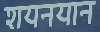

Result: 	 ISLERER9999999999999999


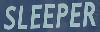

In [21]:
for _img in cropped_img:
    recognize_img(_img)

## 프로젝트를 마치며

OCR을 이용해 모델이 인식한 텍스트 이미지를 실제 테스트로 출력하여 확인해보는 프로젝트를 진행했다. 샘플을 출력해보니 영어가 아닌 문자도 영어로 인식이 되었다. 영어에 대해서만 학습을 진행한 결과이기 때문이다. 배경에 의해 문자가 다른 알파벳으로 인식이 되는 경우도 있었다. 조금 더 훈련을 시키면 충분히 해결할 수 있을 것 같다.